# Intro

### Global variables

In [53]:
LABELS_TO_AUGMENT = []
SELECT_ALL = True
BAS = False
if(BAS or SELECT_ALL): LABELS_TO_AUGMENT.append("BAS")
EBO = False
if(EBO or SELECT_ALL): LABELS_TO_AUGMENT.append("EBO")
EOS = False
if(EOS or SELECT_ALL): LABELS_TO_AUGMENT.append("EOS")
KSC = False
if(KSC or SELECT_ALL): LABELS_TO_AUGMENT.append("KSC")
LYA = False
if(LYA or SELECT_ALL): LABELS_TO_AUGMENT.append("LYA")
LYT = False
if(LYT or SELECT_ALL): LABELS_TO_AUGMENT.append("LYT")
MMZ = False
if(MMZ or SELECT_ALL): LABELS_TO_AUGMENT.append("MMZ")
MOB = False
if(MOB or SELECT_ALL): LABELS_TO_AUGMENT.append("MOB")
MON = False
if(MON or SELECT_ALL): LABELS_TO_AUGMENT.append("MON")
MYB = True
if(MYB or SELECT_ALL): LABELS_TO_AUGMENT.append("MYB")
MYO = False
if(MYO or SELECT_ALL): LABELS_TO_AUGMENT.append("MYO")
NGB = False
if(NGB or SELECT_ALL): LABELS_TO_AUGMENT.append("NGB")
NGS = False
if(NGS or SELECT_ALL): LABELS_TO_AUGMENT.append("NGS")
PMB = True
if(PMB or SELECT_ALL): LABELS_TO_AUGMENT.append("PMB")
PMO = False
if(PMO or SELECT_ALL): LABELS_TO_AUGMENT.append("PMO")

In [54]:
ORGINAL_DATASET_PATH = "/home/jbonastre/tfm/dataset/AML-Cytomorphology"
SPLIT_BALANCED_DATASET_PATH = "/home/jbonastre/tfm/dataset/DatasetSplitBalanced"
AUGMENTED_BALANCED_1000_DATASET_PATH = "/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000"

In [55]:
PARTITIONS = ['train','validation','test']
TRAIN_SIZE = 1000
VAL_SIZE = 100
SHAPE_SIDE = 144

In [56]:
LABELS = ["BAS","EBO","EOS","KSC","LYA","LYT","MMZ","MOB","MON","MYB","MYO","NGB","NGS","PMB","PMO"]
CODE_TO_LABEL = {
    0:"BAS",
    1:"EBO",
    2:"EOS",
    3:"KSC",
    4:"LYA",
    5:"LYT",
    6:"MMZ",
    7:"MOB",
    8:"MON",
    9:"MYB",
    10:"MYO",
    11:"NGB",
    12:"NGS",
    13:"PMB",
    14:"PMO",
}
LABEL_TO_CODE = {
    "BAS":0,
    "EBO":1,
    "EOS":2,
    "KSC":3,
    "LYA":4,
    "LYT":5,
    "MMZ":6,
    "MOB":7,
    "MON":8,
    "MYB":9,
    "MYO":10,
    "NGB":11,
    "NGS":12,
    "PMB":13,
    "PMO":14,
}
LABELS_ABREVIATIONS = {
    "BAS": "Basophil",
    "EBO": "Erythroblast",
    "EOS": "Eosinophil",
    "KSC": "Smudge cell",
    "LYA": "Lymphocyte (atypical)",
    "LYT": "Lymphocyte (typical)",
    "MMZ": "Metamyelocyte",
    "MOB": "Monoblast",
    "MON": "Monocyte",
    "MYB": "Myelocyte",
    "MYO": "Myeloblast",
    "NGB": "Neutrophil (band)",
    "NGS": "Neutrophil (segmented)",
    "PMB": "Promyelocyte (bilobled)",
    "PMO": "Promyelocyte",
}

### Imports

In [57]:
import pickle
import numpy as np
import keras
import os
import PIL
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import random
import math

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.utils.np_utils import to_categorical

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from os import path
import pickle

from collections import Counter


## Read dataset

In [58]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

In [59]:
def split_sample_to_partition(image, label, partition):
  if partition == 'train':
    train_images.append(image)
    train_labels.append(label)
  elif partition == 'validation':
    val_images.append(image)
    val_labels.append(label)
  elif partition == 'test':
    test_images.append(image)
    test_labels.append(label)

In [60]:
def check_partitions_count(dataset_path):
  for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    checks = []
    print(f"Checking sample count for {label}:")
    for partition in PARTITIONS:
      labels_path = os.path.join(dataset_path,partition)
      label_text = CODE_TO_LABEL[label_code]
      label_path = os.path.join(dataset_path,partition, label_text)
      label_images = os.listdir(label_path)
      count = len(label_images)
      N_SAMPLES_PER_LABEL[label_text] = count
      print(f"Expected sample count: {PARTITION_COUNT[partition]}\t observed: {count}")
      if (count < PARTITION_COUNT[partition]): checks.append(False)
      else: checks.append(True)
    if False in checks:
      raise Exception("Unexpected number of samples")
    else:
      print("OK. expected number of samples")

In [61]:
def read_from_dataset_with_partitions(dataset_path, train_to_val=False):
  for label_text in LABELS:
    label_code = LABEL_TO_CODE[label_text]
    for partition in PARTITIONS:
      # When using synthetic data i want all train data to be synthetic and use the original data just for validation.
      if(partition=='train' and train_to_val==True):
        save_partition = 'validation'
      else:
        save_partition = partition
      labels_path = os.path.join(dataset_path,partition)
      labels_texts = os.listdir(labels_path)
      n_labels = len(labels_texts)
      label_path = os.path.join(dataset_path,partition, label_text)
      label_images = os.listdir(label_path)
      print(label_path)
      print(len(label_images))
      for j,img_text in enumerate(label_images):
        print(f"{partition} {label_text}: {j}. {img_text}")
        img_path = os.path.join(dataset_path,partition,label_text,img_text)
        img = np.array(PIL.Image.open(img_path))[:,:,:3]
        img = cv2.resize(img, (SHAPE_SIDE, SHAPE_SIDE))
        split_sample_to_partition(img, LABEL_TO_CODE[label_text], save_partition)

In [62]:
read_from_dataset_with_partitions(SPLIT_BALANCED_DATASET_PATH)

/home/jbonastre/tfm/dataset/DatasetSplitBalanced/train/BAS
73
train BAS: 0. TRAIN_19_BAS.bmp
train BAS: 1. TRAIN_58_BAS.bmp
train BAS: 2. TRAIN_15_BAS.bmp
train BAS: 3. TRAIN_64_BAS.bmp
train BAS: 4. TRAIN_34_BAS.bmp
train BAS: 5. TRAIN_50_BAS.bmp
train BAS: 6. TRAIN_52_BAS.bmp
train BAS: 7. TRAIN_11_BAS.bmp
train BAS: 8. TRAIN_44_BAS.bmp
train BAS: 9. TRAIN_17_BAS.bmp
train BAS: 10. TRAIN_47_BAS.bmp
train BAS: 11. TRAIN_54_BAS.bmp
train BAS: 12. TRAIN_69_BAS.bmp
train BAS: 13. TRAIN_10_BAS.bmp
train BAS: 14. TRAIN_18_BAS.bmp
train BAS: 15. TRAIN_38_BAS.bmp
train BAS: 16. TRAIN_24_BAS.bmp
train BAS: 17. TRAIN_56_BAS.bmp
train BAS: 18. TRAIN_67_BAS.bmp
train BAS: 19. TRAIN_60_BAS.bmp
train BAS: 20. TRAIN_23_BAS.bmp
train BAS: 21. TRAIN_39_BAS.bmp
train BAS: 22. TRAIN_26_BAS.bmp
train BAS: 23. TRAIN_27_BAS.bmp
train BAS: 24. TRAIN_28_BAS.bmp
train BAS: 25. TRAIN_35_BAS.bmp
train BAS: 26. TRAIN_72_BAS.bmp
train BAS: 27. TRAIN_62_BAS.bmp
train BAS: 28. TRAIN_4_BAS.bmp
train BAS: 29. TRAIN_

train LYT: 648. TRAIN_3736_LYT.bmp
train LYT: 649. TRAIN_569_LYT.bmp
train LYT: 650. TRAIN_709_LYT.bmp
train LYT: 651. TRAIN_164_LYT.bmp
train LYT: 652. TRAIN_3612_LYT.bmp
train LYT: 653. TRAIN_272_LYT.bmp
train LYT: 654. TRAIN_2573_LYT.bmp
train LYT: 655. TRAIN_768_LYT.bmp
train LYT: 656. TRAIN_197_LYT.bmp
train LYT: 657. TRAIN_2895_LYT.bmp
train LYT: 658. TRAIN_3905_LYT.bmp
train LYT: 659. TRAIN_291_LYT.bmp
train LYT: 660. TRAIN_2798_LYT.bmp
train LYT: 661. TRAIN_1999_LYT.bmp
train LYT: 662. TRAIN_1784_LYT.bmp
train LYT: 663. TRAIN_3296_LYT.bmp
train LYT: 664. TRAIN_1580_LYT.bmp
train LYT: 665. TRAIN_2392_LYT.bmp
train LYT: 666. TRAIN_2230_LYT.bmp
train LYT: 667. TRAIN_1216_LYT.bmp
train LYT: 668. TRAIN_1590_LYT.bmp
train LYT: 669. TRAIN_3342_LYT.bmp
train LYT: 670. TRAIN_1618_LYT.bmp
train LYT: 671. TRAIN_1821_LYT.bmp
train LYT: 672. TRAIN_873_LYT.bmp
train LYT: 673. TRAIN_1121_LYT.bmp
train LYT: 674. TRAIN_2469_LYT.bmp
train LYT: 675. TRAIN_2989_LYT.bmp
train LYT: 676. TRAIN_918_LY

train LYT: 2208. TRAIN_130_LYT.bmp
train LYT: 2209. TRAIN_2048_LYT.bmp
train LYT: 2210. TRAIN_3213_LYT.bmp
train LYT: 2211. TRAIN_2317_LYT.bmp
train LYT: 2212. TRAIN_3658_LYT.bmp
train LYT: 2213. TRAIN_1007_LYT.bmp
train LYT: 2214. TRAIN_499_LYT.bmp
train LYT: 2215. TRAIN_1281_LYT.bmp
train LYT: 2216. TRAIN_3229_LYT.bmp
train LYT: 2217. TRAIN_2601_LYT.bmp
train LYT: 2218. TRAIN_2985_LYT.bmp
train LYT: 2219. TRAIN_1718_LYT.bmp
train LYT: 2220. TRAIN_2276_LYT.bmp
train LYT: 2221. TRAIN_1293_LYT.bmp
train LYT: 2222. TRAIN_3442_LYT.bmp
train LYT: 2223. TRAIN_1288_LYT.bmp
train LYT: 2224. TRAIN_1547_LYT.bmp
train LYT: 2225. TRAIN_3763_LYT.bmp
train LYT: 2226. TRAIN_2893_LYT.bmp
train LYT: 2227. TRAIN_2886_LYT.bmp
train LYT: 2228. TRAIN_2961_LYT.bmp
train LYT: 2229. TRAIN_2281_LYT.bmp
train LYT: 2230. TRAIN_977_LYT.bmp
train LYT: 2231. TRAIN_3647_LYT.bmp
train LYT: 2232. TRAIN_913_LYT.bmp
train LYT: 2233. TRAIN_71_LYT.bmp
train LYT: 2234. TRAIN_48_LYT.bmp
train LYT: 2235. TRAIN_435_LYT.bmp
t

train LYT: 3754. TRAIN_885_LYT.bmp
train LYT: 3755. TRAIN_403_LYT.bmp
train LYT: 3756. TRAIN_1700_LYT.bmp
train LYT: 3757. TRAIN_13_LYT.bmp
train LYT: 3758. TRAIN_121_LYT.bmp
train LYT: 3759. TRAIN_3238_LYT.bmp
train LYT: 3760. TRAIN_1771_LYT.bmp
train LYT: 3761. TRAIN_1411_LYT.bmp
train LYT: 3762. TRAIN_2830_LYT.bmp
train LYT: 3763. TRAIN_1740_LYT.bmp
train LYT: 3764. TRAIN_1015_LYT.bmp
train LYT: 3765. TRAIN_3176_LYT.bmp
train LYT: 3766. TRAIN_2146_LYT.bmp
train LYT: 3767. TRAIN_1060_LYT.bmp
train LYT: 3768. TRAIN_3337_LYT.bmp
train LYT: 3769. TRAIN_3193_LYT.bmp
train LYT: 3770. TRAIN_477_LYT.bmp
train LYT: 3771. TRAIN_760_LYT.bmp
train LYT: 3772. TRAIN_1823_LYT.bmp
train LYT: 3773. TRAIN_659_LYT.bmp
train LYT: 3774. TRAIN_1284_LYT.bmp
train LYT: 3775. TRAIN_3581_LYT.bmp
train LYT: 3776. TRAIN_1345_LYT.bmp
train LYT: 3777. TRAIN_1176_LYT.bmp
train LYT: 3778. TRAIN_925_LYT.bmp
train LYT: 3779. TRAIN_1739_LYT.bmp
train LYT: 3780. TRAIN_1565_LYT.bmp
train LYT: 3781. TRAIN_469_LYT.bmp
tr

train MON: 1292. TRAIN_1512_MON.bmp
train MON: 1293. TRAIN_546_MON.bmp
train MON: 1294. TRAIN_757_MON.bmp
train MON: 1295. TRAIN_783_MON.bmp
train MON: 1296. TRAIN_1778_MON.bmp
train MON: 1297. TRAIN_651_MON.bmp
train MON: 1298. TRAIN_865_MON.bmp
train MON: 1299. TRAIN_1439_MON.bmp
train MON: 1300. TRAIN_98_MON.bmp
train MON: 1301. TRAIN_1220_MON.bmp
train MON: 1302. TRAIN_1731_MON.bmp
train MON: 1303. TRAIN_630_MON.bmp
train MON: 1304. TRAIN_937_MON.bmp
train MON: 1305. TRAIN_1675_MON.bmp
train MON: 1306. TRAIN_1755_MON.bmp
train MON: 1307. TRAIN_1171_MON.bmp
train MON: 1308. TRAIN_832_MON.bmp
train MON: 1309. TRAIN_351_MON.bmp
train MON: 1310. TRAIN_297_MON.bmp
train MON: 1311. TRAIN_1626_MON.bmp
train MON: 1312. TRAIN_766_MON.bmp
train MON: 1313. TRAIN_29_MON.bmp
train MON: 1314. TRAIN_844_MON.bmp
train MON: 1315. TRAIN_15_MON.bmp
train MON: 1316. TRAIN_657_MON.bmp
train MON: 1317. TRAIN_313_MON.bmp
train MON: 1318. TRAIN_898_MON.bmp
train MON: 1319. TRAIN_592_MON.bmp
train MON: 132

train MYO: 980. TRAIN_957_MYO.bmp
train MYO: 981. TRAIN_927_MYO.bmp
train MYO: 982. TRAIN_2572_MYO.bmp
train MYO: 983. TRAIN_3240_MYO.bmp
train MYO: 984. TRAIN_1109_MYO.bmp
train MYO: 985. TRAIN_1793_MYO.bmp
train MYO: 986. TRAIN_2924_MYO.bmp
train MYO: 987. TRAIN_3079_MYO.bmp
train MYO: 988. TRAIN_714_MYO.bmp
train MYO: 989. TRAIN_814_MYO.bmp
train MYO: 990. TRAIN_2659_MYO.bmp
train MYO: 991. TRAIN_1120_MYO.bmp
train MYO: 992. TRAIN_137_MYO.bmp
train MYO: 993. TRAIN_2851_MYO.bmp
train MYO: 994. TRAIN_2706_MYO.bmp
train MYO: 995. TRAIN_2385_MYO.bmp
train MYO: 996. TRAIN_595_MYO.bmp
train MYO: 997. TRAIN_2347_MYO.bmp
train MYO: 998. TRAIN_1434_MYO.bmp
train MYO: 999. TRAIN_1011_MYO.bmp
train MYO: 1000. TRAIN_2894_MYO.bmp
train MYO: 1001. TRAIN_3241_MYO.bmp
train MYO: 1002. TRAIN_2831_MYO.bmp
train MYO: 1003. TRAIN_343_MYO.bmp
train MYO: 1004. TRAIN_2357_MYO.bmp
train MYO: 1005. TRAIN_3252_MYO.bmp
train MYO: 1006. TRAIN_2117_MYO.bmp
train MYO: 1007. TRAIN_2816_MYO.bmp
train MYO: 1008. TR

train MYO: 2504. TRAIN_146_MYO.bmp
train MYO: 2505. TRAIN_2054_MYO.bmp
train MYO: 2506. TRAIN_942_MYO.bmp
train MYO: 2507. TRAIN_1394_MYO.bmp
train MYO: 2508. TRAIN_1965_MYO.bmp
train MYO: 2509. TRAIN_139_MYO.bmp
train MYO: 2510. TRAIN_703_MYO.bmp
train MYO: 2511. TRAIN_1440_MYO.bmp
train MYO: 2512. TRAIN_1595_MYO.bmp
train MYO: 2513. TRAIN_3096_MYO.bmp
train MYO: 2514. TRAIN_1000_MYO.bmp
train MYO: 2515. TRAIN_2504_MYO.bmp
train MYO: 2516. TRAIN_1517_MYO.bmp
train MYO: 2517. TRAIN_1325_MYO.bmp
train MYO: 2518. TRAIN_265_MYO.bmp
train MYO: 2519. TRAIN_1093_MYO.bmp
train MYO: 2520. TRAIN_2299_MYO.bmp
train MYO: 2521. TRAIN_672_MYO.bmp
train MYO: 2522. TRAIN_2003_MYO.bmp
train MYO: 2523. TRAIN_739_MYO.bmp
train MYO: 2524. TRAIN_822_MYO.bmp
train MYO: 2525. TRAIN_2247_MYO.bmp
train MYO: 2526. TRAIN_1184_MYO.bmp
train MYO: 2527. TRAIN_975_MYO.bmp
train MYO: 2528. TRAIN_2465_MYO.bmp
train MYO: 2529. TRAIN_2893_MYO.bmp
train MYO: 2530. TRAIN_1267_MYO.bmp
train MYO: 2531. TRAIN_619_MYO.bmp
tr

train NGS: 606. TRAIN_7602_NGS.bmp
train NGS: 607. TRAIN_2628_NGS.bmp
train NGS: 608. TRAIN_5569_NGS.bmp
train NGS: 609. TRAIN_3772_NGS.bmp
train NGS: 610. TRAIN_8109_NGS.bmp
train NGS: 611. TRAIN_1470_NGS.bmp
train NGS: 612. TRAIN_7240_NGS.bmp
train NGS: 613. TRAIN_4418_NGS.bmp
train NGS: 614. TRAIN_4714_NGS.bmp
train NGS: 615. TRAIN_3912_NGS.bmp
train NGS: 616. TRAIN_4619_NGS.bmp
train NGS: 617. TRAIN_2077_NGS.bmp
train NGS: 618. TRAIN_271_NGS.bmp
train NGS: 619. TRAIN_6322_NGS.bmp
train NGS: 620. TRAIN_4205_NGS.bmp
train NGS: 621. TRAIN_7824_NGS.bmp
train NGS: 622. TRAIN_414_NGS.bmp
train NGS: 623. TRAIN_8173_NGS.bmp
train NGS: 624. TRAIN_5152_NGS.bmp
train NGS: 625. TRAIN_4529_NGS.bmp
train NGS: 626. TRAIN_1403_NGS.bmp
train NGS: 627. TRAIN_2435_NGS.bmp
train NGS: 628. TRAIN_5411_NGS.bmp
train NGS: 629. TRAIN_4610_NGS.bmp
train NGS: 630. TRAIN_6517_NGS.bmp
train NGS: 631. TRAIN_3484_NGS.bmp
train NGS: 632. TRAIN_1062_NGS.bmp
train NGS: 633. TRAIN_2928_NGS.bmp
train NGS: 634. TRAIN_

train NGS: 2123. TRAIN_4990_NGS.bmp
train NGS: 2124. TRAIN_4705_NGS.bmp
train NGS: 2125. TRAIN_3820_NGS.bmp
train NGS: 2126. TRAIN_4046_NGS.bmp
train NGS: 2127. TRAIN_1843_NGS.bmp
train NGS: 2128. TRAIN_616_NGS.bmp
train NGS: 2129. TRAIN_5702_NGS.bmp
train NGS: 2130. TRAIN_1473_NGS.bmp
train NGS: 2131. TRAIN_2901_NGS.bmp
train NGS: 2132. TRAIN_3416_NGS.bmp
train NGS: 2133. TRAIN_5341_NGS.bmp
train NGS: 2134. TRAIN_3838_NGS.bmp
train NGS: 2135. TRAIN_280_NGS.bmp
train NGS: 2136. TRAIN_4779_NGS.bmp
train NGS: 2137. TRAIN_7253_NGS.bmp
train NGS: 2138. TRAIN_2387_NGS.bmp
train NGS: 2139. TRAIN_2961_NGS.bmp
train NGS: 2140. TRAIN_2470_NGS.bmp
train NGS: 2141. TRAIN_8392_NGS.bmp
train NGS: 2142. TRAIN_124_NGS.bmp
train NGS: 2143. TRAIN_8349_NGS.bmp
train NGS: 2144. TRAIN_1491_NGS.bmp
train NGS: 2145. TRAIN_2133_NGS.bmp
train NGS: 2146. TRAIN_5424_NGS.bmp
train NGS: 2147. TRAIN_7433_NGS.bmp
train NGS: 2148. TRAIN_568_NGS.bmp
train NGS: 2149. TRAIN_1340_NGS.bmp
train NGS: 2150. TRAIN_858_NGS.b

train NGS: 3653. TRAIN_1857_NGS.bmp
train NGS: 3654. TRAIN_4850_NGS.bmp
train NGS: 3655. TRAIN_3181_NGS.bmp
train NGS: 3656. TRAIN_4640_NGS.bmp
train NGS: 3657. TRAIN_634_NGS.bmp
train NGS: 3658. TRAIN_5881_NGS.bmp
train NGS: 3659. TRAIN_2098_NGS.bmp
train NGS: 3660. TRAIN_879_NGS.bmp
train NGS: 3661. TRAIN_7981_NGS.bmp
train NGS: 3662. TRAIN_3891_NGS.bmp
train NGS: 3663. TRAIN_3644_NGS.bmp
train NGS: 3664. TRAIN_6578_NGS.bmp
train NGS: 3665. TRAIN_6092_NGS.bmp
train NGS: 3666. TRAIN_6867_NGS.bmp
train NGS: 3667. TRAIN_3461_NGS.bmp
train NGS: 3668. TRAIN_4030_NGS.bmp
train NGS: 3669. TRAIN_7408_NGS.bmp
train NGS: 3670. TRAIN_1978_NGS.bmp
train NGS: 3671. TRAIN_4712_NGS.bmp
train NGS: 3672. TRAIN_59_NGS.bmp
train NGS: 3673. TRAIN_4646_NGS.bmp
train NGS: 3674. TRAIN_1024_NGS.bmp
train NGS: 3675. TRAIN_5488_NGS.bmp
train NGS: 3676. TRAIN_7876_NGS.bmp
train NGS: 3677. TRAIN_3385_NGS.bmp
train NGS: 3678. TRAIN_2257_NGS.bmp
train NGS: 3679. TRAIN_8065_NGS.bmp
train NGS: 3680. TRAIN_1153_NGS.

train NGS: 5202. TRAIN_6122_NGS.bmp
train NGS: 5203. TRAIN_8451_NGS.bmp
train NGS: 5204. TRAIN_4792_NGS.bmp
train NGS: 5205. TRAIN_3788_NGS.bmp
train NGS: 5206. TRAIN_4314_NGS.bmp
train NGS: 5207. TRAIN_6139_NGS.bmp
train NGS: 5208. TRAIN_4984_NGS.bmp
train NGS: 5209. TRAIN_327_NGS.bmp
train NGS: 5210. TRAIN_7264_NGS.bmp
train NGS: 5211. TRAIN_8342_NGS.bmp
train NGS: 5212. TRAIN_1186_NGS.bmp
train NGS: 5213. TRAIN_5008_NGS.bmp
train NGS: 5214. TRAIN_8224_NGS.bmp
train NGS: 5215. TRAIN_6727_NGS.bmp
train NGS: 5216. TRAIN_3607_NGS.bmp
train NGS: 5217. TRAIN_4638_NGS.bmp
train NGS: 5218. TRAIN_6790_NGS.bmp
train NGS: 5219. TRAIN_3617_NGS.bmp
train NGS: 5220. TRAIN_3746_NGS.bmp
train NGS: 5221. TRAIN_6922_NGS.bmp
train NGS: 5222. TRAIN_1348_NGS.bmp
train NGS: 5223. TRAIN_484_NGS.bmp
train NGS: 5224. TRAIN_6110_NGS.bmp
train NGS: 5225. TRAIN_60_NGS.bmp
train NGS: 5226. TRAIN_1093_NGS.bmp
train NGS: 5227. TRAIN_7471_NGS.bmp
train NGS: 5228. TRAIN_1312_NGS.bmp
train NGS: 5229. TRAIN_2908_NGS.

train NGS: 6758. TRAIN_3217_NGS.bmp
train NGS: 6759. TRAIN_7796_NGS.bmp
train NGS: 6760. TRAIN_2794_NGS.bmp
train NGS: 6761. TRAIN_514_NGS.bmp
train NGS: 6762. TRAIN_4663_NGS.bmp
train NGS: 6763. TRAIN_4633_NGS.bmp
train NGS: 6764. TRAIN_4326_NGS.bmp
train NGS: 6765. TRAIN_4928_NGS.bmp
train NGS: 6766. TRAIN_2452_NGS.bmp
train NGS: 6767. TRAIN_3215_NGS.bmp
train NGS: 6768. TRAIN_3911_NGS.bmp
train NGS: 6769. TRAIN_8461_NGS.bmp
train NGS: 6770. TRAIN_146_NGS.bmp
train NGS: 6771. TRAIN_942_NGS.bmp
train NGS: 6772. TRAIN_1681_NGS.bmp
train NGS: 6773. TRAIN_2353_NGS.bmp
train NGS: 6774. TRAIN_2762_NGS.bmp
train NGS: 6775. TRAIN_5342_NGS.bmp
train NGS: 6776. TRAIN_4726_NGS.bmp
train NGS: 6777. TRAIN_949_NGS.bmp
train NGS: 6778. TRAIN_6250_NGS.bmp
train NGS: 6779. TRAIN_1359_NGS.bmp
train NGS: 6780. TRAIN_7810_NGS.bmp
train NGS: 6781. TRAIN_5073_NGS.bmp
train NGS: 6782. TRAIN_4187_NGS.bmp
train NGS: 6783. TRAIN_1660_NGS.bmp
train NGS: 6784. TRAIN_4552_NGS.bmp
train NGS: 6785. TRAIN_3169_NGS.

train NGS: 8303. TRAIN_965_NGS.bmp
train NGS: 8304. TRAIN_619_NGS.bmp
train NGS: 8305. TRAIN_7619_NGS.bmp
train NGS: 8306. TRAIN_7653_NGS.bmp
train NGS: 8307. TRAIN_6616_NGS.bmp
train NGS: 8308. TRAIN_5401_NGS.bmp
train NGS: 8309. TRAIN_7474_NGS.bmp
train NGS: 8310. TRAIN_4833_NGS.bmp
train NGS: 8311. TRAIN_6075_NGS.bmp
train NGS: 8312. TRAIN_7666_NGS.bmp
train NGS: 8313. TRAIN_3710_NGS.bmp
train NGS: 8314. TRAIN_5454_NGS.bmp
train NGS: 8315. TRAIN_8067_NGS.bmp
train NGS: 8316. TRAIN_6330_NGS.bmp
train NGS: 8317. TRAIN_3279_NGS.bmp
train NGS: 8318. TRAIN_5167_NGS.bmp
train NGS: 8319. TRAIN_3959_NGS.bmp
train NGS: 8320. TRAIN_3561_NGS.bmp
train NGS: 8321. TRAIN_2819_NGS.bmp
train NGS: 8322. TRAIN_5501_NGS.bmp
train NGS: 8323. TRAIN_4686_NGS.bmp
train NGS: 8324. TRAIN_6234_NGS.bmp
train NGS: 8325. TRAIN_5409_NGS.bmp
train NGS: 8326. TRAIN_1668_NGS.bmp
train NGS: 8327. TRAIN_5278_NGS.bmp
train NGS: 8328. TRAIN_1563_NGS.bmp
train NGS: 8329. TRAIN_1374_NGS.bmp
train NGS: 8330. TRAIN_6348_NG

In [63]:
len(train_images)
print(type(train_images[0]))

<class 'numpy.ndarray'>


## Data Augmentation

### Angle distribution
When rotation aproximates 45 degrees, cropping area maximices. With this distribution, there is a decreasing frequency for every 45 degrees

In [64]:
def get_angle_distribution(slope):
    arr = range(0,46)
    p = np.array([1/((i*slope)+1) for i in arr])
    p /= p.sum()
    base_angle = np.random.choice(arr, p=p)

    quarter = random.randint(0,7)
    angle = base_angle + 45*quarter

    return angle

In [65]:
def test_angle_distribution(slope):
    dist = []
    for i in range(10000):
        dist.append(get_angle_distribution(slope))
    return dist

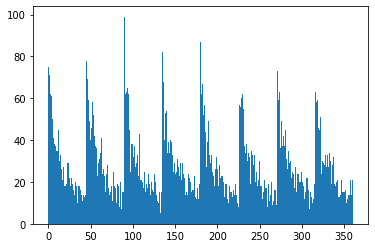

In [66]:
angles_dist = test_angle_distribution(0.1)
plt.hist(angles_dist, bins=360);

### Testing distribution
Code to visualy see how the distribution beeing placed. It will be used for the data augmentation probabilities.

In [67]:
def get_distribution(min_num, max_num, slope):
    arr = range(min_num,max_num)
    p = np.array([1/((i*slope)+1) for i in arr])
    p /= p.sum()
    choice = np.random.choice(arr, p=p)
    return choice

In [70]:
def test_distribution(min_num,max_num, slope):
    dist = []
    for i in range(1000):
        dist.append(get_distribution(min_num,max_num,slope))
    return dist

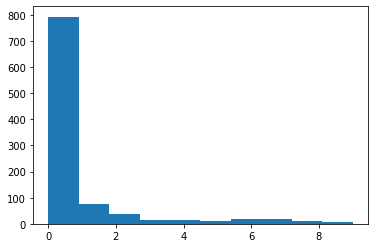

In [71]:
min_num = 0
max_num = 10
slope = 10
dist = test_distribution(min_num, max_num, slope)
plt.hist(dist, bins=max_num);
# [print(f"{count}: {dist.count(count)}") for count in range(1,max_num+1)];

### Rotate image code

In [72]:
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

### Increment contrast

In [73]:
def increment_contrast(image):
    clipLimit = get_distribution(1,10,5)
    gridSize = get_distribution(1,8,3)
    tileGridSize=(gridSize,gridSize)

    # print(f"clipLimit: {clipLimit}\ttileGridSize:{tileGridSize}")

    # converting to LAB color space
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return enhanced_img

### Full data augmentation chain

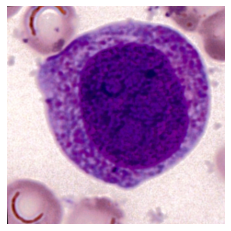

In [160]:
def data_aug(image):
    # 0.3 probability of not making any augmentation
    if(random.randint(0,1) > 0.7): return image


    # flip the image horizontally
    if(random.randint(0,1) > 0.5):
        image = cv2.flip(image, random.randint(-1,1))

    # increment contrast of the image
    if(random.randint(0,1) > 0.5):
        image = increment_contrast(image)

    # blur the image with a probability distribution
    if(random.randint(0,1) > 0.5):
        blur_size = get_distribution(1,25,0.4)
        image = cv2.blur(image, (blur_size,blur_size))

    # add noise to the image
    if(random.randint(0,1) > 0.5):
        noise_value = get_distribution(0,100,0.5)
        noise = np.zeros(image.shape, np.uint8)
        cv2.randn(noise, int(noise_value), int(noise_value))
        image = cv2.add(image, noise)

    # rotate the image
    if(random.randint(0,1) > 0.5):
        angle = get_angle_distribution(0.1)
        image_height, image_width = image.shape[0:2]
        image_rotated = rotate_image(image, angle)
        image = crop_around_center(
            image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(angle)
            )
        )

    # resize the image to fit 400,400 after beeing cropped
    image = cv2.resize(image, (400,400))

    return image

image_path = os.path.join(ORGINAL_DATASET_PATH,'PMO', 'PMO_0070.tiff')
image = np.array(PIL.Image.open(image_path))[:,:,:3]
augmented_image = data_aug(image)
plt.axis('off')
plt.imshow(augmented_image);

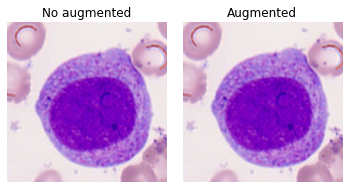

In [85]:
image_path = os.path.join(ORGINAL_DATASET_PATH,'PMO', 'PMO_0070.tiff')
image = np.array(PIL.Image.open(image_path))[:,:,:3]
augmented_image = data_aug(image)

# create a figure with a 2x4 grid of subplots
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('No augmented')
ax[1].imshow(augmented_image)
ax[1].axis('off')
ax[1].set_title('Augmented')

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Balance data

### Check current data distribution

In [211]:
def data_distribution():
  for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    
    print(f"LABEL {label} ({label_code})")
    label_imgs = [img for idx, img in enumerate(train_images) if train_labels[idx]==label_code]
    print(f"\ttrain: ({len(label_imgs)})")
    
    label_imgs = [img for idx, img in enumerate(val_images) if val_labels[idx]==label_code]
    print(f"\tvalidation: ({len(label_imgs)})")
    
    label_imgs = [img for idx, img in enumerate(test_images) if test_labels[idx]==label_code]
    print(f"\ttest: ({len(label_imgs)})")

data_distribution()

LABEL BAS (0)
	train: (73)
	validation: (4)
	test: (2)
LABEL EBO (1)
	train: (72)
	validation: (4)
	test: (2)
LABEL EOS (2)
	train: (418)
	validation: (4)
	test: (2)
LABEL KSC (3)
	train: (9)
	validation: (4)
	test: (2)
LABEL LYA (4)
	train: (5)
	validation: (4)
	test: (2)
LABEL LYT (5)
	train: (3931)
	validation: (4)
	test: (2)
LABEL MMZ (6)
	train: (9)
	validation: (4)
	test: (2)
LABEL MOB (7)
	train: (20)
	validation: (4)
	test: (2)
LABEL MON (8)
	train: (1783)
	validation: (4)
	test: (2)
LABEL MYB (9)
	train: (36)
	validation: (4)
	test: (2)
LABEL MYO (10)
	train: (3262)
	validation: (4)
	test: (2)
LABEL NGB (11)
	train: (103)
	validation: (4)
	test: (2)
LABEL NGS (12)
	train: (8478)
	validation: (4)
	test: (2)
LABEL PMB (13)
	train: (12)
	validation: (4)
	test: (2)
LABEL PMO (14)
	train: (64)
	validation: (4)
	test: (2)


## Augment

In [154]:
def fill_with_aug(imgs_list, n_images):

    if(n_images <= 0):
        return imgs_list

    new_images = []

    for n in range(n_images):
        img = random.choice(imgs_list)
        img = data_aug(img)
        new_images.append(img)

    new_images = new_images + imgs_list
    
    random.shuffle(new_images)
    random.shuffle(new_images)
    random.shuffle(new_images)

    return new_images

In [188]:
len([img for idx, img in enumerate(train_images) if train_labels[idx]==LABEL_TO_CODE['BAS']])

73

In [212]:
train_augmented_dataset = [[] for i in range(15)]
val_augmented_dataset = [[] for i in range(15)]
test_augmented_dataset = [[] for i in range(15)]

In [233]:
for label in [l for l in LABELS if l in LABELS_TO_AUGMENT]:
    label_code = LABEL_TO_CODE[label]
    
    # TRAIN
    print(f"LABEL {label} ({label_code})")
    train_label_imgs = [img for idx, img in enumerate(train_images) if train_labels[idx]==label_code]
    train_count = len(train_label_imgs)
    train_labels_to_augment = TRAIN_SIZE - train_count
    print(f"\ttrain: ({train_count})  labels to augment: {train_labels_to_augment}")
    
    train_augmented_dataset[label_code] = fill_with_aug(train_label_imgs[:TRAIN_SIZE], train_labels_to_augment)
    print(f"\ttrain augmented to: {len(train_augmented_dataset[label_code])}")
    
    
    
    # VALIDATION
    val_label_imgs = [img for idx, img in enumerate(val_images) if val_labels[idx]==label_code]
    val_count = len(val_label_imgs)
    val_labels_to_augment = VAL_SIZE - val_count
    print(f"\tvalidation: ({val_count}) labels to augment: {val_labels_to_augment}")
    
    # if train has more samples than needed, use them for validation 
    if(train_labels_to_augment < 0):
        val_labels_to_augment = 0
        train_to_val_imgs = train_label_imgs[TRAIN_SIZE:TRAIN_SIZE+100]
        val_augmented_dataset[label_code] = train_to_val_imgs
    else:
        val_augmented_dataset[label_code] = fill_with_aug(val_label_imgs[:VAL_SIZE], val_labels_to_augment)    
    print(f"\tval augmented to: {len(val_augmented_dataset[label_code])}")
    
                                                                     
                                                                     
    # TEST
    test_label_imgs = [img for idx, img in enumerate(test_images) if test_labels[idx]==label_code]
    print(f"\ttest: ({len(test_label_imgs)})")
    test_augmented_dataset[label_code] = test_label_imgs 
    print(f"\ttest augmented to: {len(test_augmented_dataset[label_code])}")

LABEL BAS (0)
	train: (73)  labels to augment: 927
	train augmented to: 1000
	validation: (4) labels to augment: 96
	val augmented to: 100
	test: (2)
	test augmented to: 2
LABEL EBO (1)
	train: (72)  labels to augment: 928
	train augmented to: 1000
	validation: (4) labels to augment: 96
	val augmented to: 100
	test: (2)
	test augmented to: 2
LABEL EOS (2)
	train: (418)  labels to augment: 582
	train augmented to: 1000
	validation: (4) labels to augment: 96
	val augmented to: 100
	test: (2)
	test augmented to: 2
LABEL KSC (3)
	train: (9)  labels to augment: 991
	train augmented to: 1000
	validation: (4) labels to augment: 96
	val augmented to: 100
	test: (2)
	test augmented to: 2
LABEL LYA (4)
	train: (5)  labels to augment: 995
	train augmented to: 1000
	validation: (4) labels to augment: 96
	val augmented to: 100
	test: (2)
	test augmented to: 2
LABEL LYT (5)
	train: (3931)  labels to augment: -2931
	train augmented to: 1000
	validation: (4) labels to augment: 96
	val augmented to: 10

### Check resultant dataset

In [234]:
print("TRAIN")
for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    count = len(train_augmented_dataset[label_code])
    print('\t{:<2s} - {:<25s} {:<10s} {:<10s}'.format(str(label_code),str(LABELS_ABREVIATIONS[label]),f"({label})",str(count)))
        
print("VALIDATION")
for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    count = len(val_augmented_dataset[label_code])
    print('\t{:<2s} - {:<25s} {:<10s} {:<10s}'.format(str(label_code),str(LABELS_ABREVIATIONS[label]),f"({label})",str(count)))
            
print("TEST")
for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    count = len(test_augmented_dataset[label_code])
    print('\t{:<2s} - {:<25s} {:<10s} {:<10s}'.format(str(label_code),str(LABELS_ABREVIATIONS[label]),f"({label})",str(count)))
    

TRAIN
	0  - Basophil                  (BAS)      1000      
	1  - Erythroblast              (EBO)      1000      
	2  - Eosinophil                (EOS)      1000      
	3  - Smudge cell               (KSC)      1000      
	4  - Lymphocyte (atypical)     (LYA)      1000      
	5  - Lymphocyte (typical)      (LYT)      1000      
	6  - Metamyelocyte             (MMZ)      1000      
	7  - Monoblast                 (MOB)      1000      
	8  - Monocyte                  (MON)      1000      
	9  - Myelocyte                 (MYB)      1000      
	10 - Myeloblast                (MYO)      1000      
	11 - Neutrophil (band)         (NGB)      1000      
	12 - Neutrophil (segmented)    (NGS)      1000      
	13 - Promyelocyte (bilobled)   (PMB)      1000      
	14 - Promyelocyte              (PMO)      1000      
VALIDATION
	0  - Basophil                  (BAS)      100       
	1  - Erythroblast              (EBO)      100       
	2  - Eosinophil                (EOS)      100       
	3  - Smudg

## Save it

In [237]:
# DATASET
if(not os.path.isdir(AUGMENTED_BALANCED_1000_DATASET_PATH)): os.mkdir(AUGMENTED_BALANCED_1000_DATASET_PATH)

# TRAIN
train_path = os.path.join(AUGMENTED_BALANCED_1000_DATASET_PATH, 'train')
if(not os.path.isdir(train_path)): os.mkdir(train_path)
# VAL
val_path = os.path.join(AUGMENTED_BALANCED_1000_DATASET_PATH, 'validation')
if(not os.path.isdir(val_path)): os.mkdir(val_path)
# TEST
test_path = os.path.join(AUGMENTED_BALANCED_1000_DATASET_PATH, 'test')
if(not os.path.isdir(test_path)): os.mkdir(test_path)

# SAVE
for label in [l for l in LABELS if l in LABELS_TO_AUGMENT]:
  label_code = LABEL_TO_CODE[label]
  print(f"saving {label} ({label_code}) images")

  # train
  print("\tsaving train images", end="")
  label_train_dict_path = os.path.join(train_path,label)
  if(not os.path.isdir(label_train_dict_path)): os.mkdir(label_train_dict_path)
  print(label_train_dict_path)

  for idx,train_img in enumerate(train_augmented_dataset[label_code]):
    im = PIL.Image.fromarray(train_img)
    path = os.path.join(label_train_dict_path,f"TRAIN_{idx}.bmp")
    print(f"\t\t{path}")
    im.save(path)


  # val
  print("\tsaving val images", end="")
  label_val_dict_path = os.path.join(val_path,label)
  if(not os.path.isdir(label_val_dict_path)): os.mkdir(label_val_dict_path)
  print(label_val_dict_path)

  for idx,val_img in enumerate(val_augmented_dataset[label_code]):
    im = PIL.Image.fromarray(val_img)
    path = os.path.join(label_val_dict_path,f"VAL_{idx}.bmp")
    print(f"\t\t{path}")
    im.save(path)


  # test
  print("\tsaving test images", end="")
  label_test_dict_path = os.path.join(test_path,label)
  if(not os.path.isdir(label_test_dict_path)): os.mkdir(label_test_dict_path)
  print(label_test_dict_path)

  for idx,test_img in enumerate(test_augmented_dataset[label_code]):
    im = PIL.Image.fromarray(test_img)
    path = os.path.join(label_test_dict_path,f"TEST_{idx}.bmp")
    print(f"\t\t{path}")
    im.save(path)

saving BAS (0) images
	saving train images/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_0.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_1.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_2.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_3.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_4.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_5.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_6.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_7.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_8.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_9.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_10.bmp

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_154.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_155.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_156.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_157.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_158.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_159.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_160.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_161.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_162.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_163.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_164.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_165.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_444.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_445.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_446.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_447.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_448.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_449.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_450.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_451.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_452.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_453.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_454.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_455.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_730.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_731.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_732.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_733.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_734.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_735.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_736.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_737.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_738.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_739.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_740.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/BAS/TRAIN_741.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_10.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_11.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_12.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_13.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_14.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_15.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_16.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_17.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_18.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_19.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/BAS/VAL_20.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/valida

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_181.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_182.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_183.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_184.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_185.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_186.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_187.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_188.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_189.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_190.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_191.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_192.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_446.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_447.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_448.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_449.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_450.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_451.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_452.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_453.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_454.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_455.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_456.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_457.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_682.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_683.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_684.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_685.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_686.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_687.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_688.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_689.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_690.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_691.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_692.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_693.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_919.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_920.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_921.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_922.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_923.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_924.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_925.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_926.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_927.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_928.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_929.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EBO/TRAIN_930.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_158.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_159.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_160.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_161.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_162.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_163.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_164.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_165.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_166.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_167.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_168.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_169.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_530.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_531.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_532.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_533.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_534.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_535.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_536.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_537.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_538.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_539.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_540.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_541.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_906.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_907.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_908.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_909.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_910.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_911.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_912.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_913.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_914.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_915.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_916.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/EOS/TRAIN_917.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_82.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_83.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_84.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_85.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_86.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_87.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_88.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_89.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_90.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_91.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_92.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_93.bmp
		/home/jbonastr

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_364.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_365.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_366.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_367.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_368.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_369.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_370.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_371.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_372.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_373.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_374.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_375.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_624.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_625.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_626.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_627.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_628.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_629.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_630.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_631.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_632.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_633.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_634.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_635.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_881.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_882.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_883.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_884.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_885.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_886.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_887.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_888.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_889.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_890.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_891.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/KSC/TRAIN_892.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_57.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_58.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_59.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_60.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_61.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_62.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_63.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_64.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_65.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_66.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_67.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_68.bmp
		/home/jbonastr

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_318.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_319.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_320.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_321.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_322.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_323.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_324.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_325.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_326.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_327.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_328.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_329.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_577.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_578.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_579.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_580.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_581.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_582.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_583.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_584.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_585.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_586.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_587.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_588.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_836.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_837.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_838.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_839.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_840.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_841.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_842.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_843.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_844.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_845.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_846.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYA/TRAIN_847.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/LYA/VAL_96.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/LYA/VAL_97.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/LYA/VAL_98.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/LYA/VAL_99.bmp
	saving test images/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/test/LYA
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/test/LYA/TEST_0.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/test/LYA/TEST_1.bmp
saving LYT (5) images
	saving train images/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_0.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_1.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_2.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_747.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_748.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_749.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_750.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_751.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_752.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_753.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_754.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_755.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_756.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_757.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/LYT/TRAIN_758.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_133.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_134.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_135.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_136.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_137.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_138.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_139.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_140.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_141.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_142.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_143.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_144.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_385.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_386.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_387.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_388.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_389.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_390.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_391.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_392.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_393.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_394.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_395.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_396.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_660.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_661.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_662.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_663.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_664.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_665.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_666.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_667.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_668.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_669.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_670.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_671.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_892.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_893.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_894.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_895.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_896.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_897.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_898.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_899.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_900.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_901.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_902.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MMZ/TRAIN_903.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_25.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_26.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_27.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_28.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_29.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_30.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_31.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_32.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_33.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_34.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MMZ/VAL_35.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/valida

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_51.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_52.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_53.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_54.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_55.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_56.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_57.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_58.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_59.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_60.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_61.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_62.bmp
		/home/jbonastr

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_313.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_314.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_315.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_316.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_317.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_318.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_319.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_320.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_321.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_322.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_323.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_324.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_561.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_562.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_563.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_564.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_565.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_566.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_567.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_568.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_569.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_570.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_571.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_572.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_799.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_800.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_801.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_802.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_803.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_804.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_805.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_806.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_807.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_808.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_809.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MOB/TRAIN_810.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_55.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_56.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_57.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_58.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_59.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_60.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_61.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_62.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_63.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_64.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/MOB/VAL_65.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/valida

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_610.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_611.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_612.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_613.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_614.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_615.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_616.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_617.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_618.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_619.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_620.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MON/TRAIN_621.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_80.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_81.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_82.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_83.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_84.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_85.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_86.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_87.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_88.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_89.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_90.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_91.bmp
		/home/jbonastr

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_330.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_331.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_332.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_333.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_334.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_335.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_336.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_337.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_338.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_339.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_340.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_341.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_604.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_605.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_606.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_607.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_608.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_609.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_610.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_611.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_612.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_613.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_614.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_615.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_884.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_885.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_886.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_887.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_888.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_889.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_890.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_891.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_892.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_893.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_894.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYB/TRAIN_895.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_140.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_141.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_142.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_143.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_144.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_145.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_146.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_147.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_148.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_149.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_150.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_151.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_862.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_863.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_864.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_865.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_866.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_867.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_868.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_869.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_870.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_871.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_872.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/MYO/TRAIN_873.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_177.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_178.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_179.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_180.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_181.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_182.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_183.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_184.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_185.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_186.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_187.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_188.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_395.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_396.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_397.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_398.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_399.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_400.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_401.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_402.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_403.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_404.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_405.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_406.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_658.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_659.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_660.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_661.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_662.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_663.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_664.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_665.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_666.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_667.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_668.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_669.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_899.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_900.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_901.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_902.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_903.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_904.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_905.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_906.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_907.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_908.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_909.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGB/TRAIN_910.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_137.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_138.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_139.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_140.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_141.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_142.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_143.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_144.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_145.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_146.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_147.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_148.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_781.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_782.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_783.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_784.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_785.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_786.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_787.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_788.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_789.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_790.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_791.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/NGS/TRAIN_792.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_144.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_145.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_146.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_147.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_148.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_149.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_150.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_151.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_152.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_153.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_154.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_155.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_395.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_396.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_397.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_398.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_399.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_400.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_401.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_402.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_403.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_404.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_405.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_406.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_651.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_652.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_653.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_654.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_655.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_656.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_657.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_658.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_659.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_660.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_661.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_662.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_884.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_885.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_886.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_887.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_888.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_889.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_890.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_891.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_892.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_893.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_894.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMB/TRAIN_895.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_30.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_31.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_32.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_33.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_34.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_35.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_36.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_37.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_38.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_39.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_40.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_41.bmp
		/home/jbonastr

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_308.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_309.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_310.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_311.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_312.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_313.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_314.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_315.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_316.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_317.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_318.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_319.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_511.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_512.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_513.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_514.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_515.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_516.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_517.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_518.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_519.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_520.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_521.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_522.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_776.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_777.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_778.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_779.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_780.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_781.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_782.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_783.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_784.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_785.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_786.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/train/PMO/TRAIN_787.bmp
		/h

		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_20.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_21.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_22.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_23.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_24.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_25.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_26.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_27.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_28.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_29.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/validation/PMO/VAL_30.bmp
		/home/jbonastre/tfm/dataset/DatasetAugmentedBalanced1000/valida

### Balance data with augmentation

In [ ]:
def fill_with_aug(imgs_list, n_images):
  list_len = len(imgs_list)
  dif = n_images - list_len

  if(dif < 0):
    return imgs_list[:n_images]

  new_images = []

  for n in range(dif):
    img = random.choice(imgs_list)
    img = data_aug(img)
    new_images.append(img)

  new_images = new_images + imgs_list

  return new_images

In [59]:
for label in [l for l in LABELS if l in LABELS_TO_AUGMENT]:
    label_code = LABEL_TO_CODE[label]
    label_imgs = [img for idx, img in enumerate(images) if labels[idx]==label_code]
    print(f"{label} - {label_code} ({len(label_imgs)}) ", end="")

    aug_images = label_imgs[5:]
    limit = int(np.ceil(len(aug_images)*0.1))
    print(f"\t aug_images: {len(aug_images)} - limit {limit}", end="")
    temp_train_imgs = aug_images[limit:]
    temp_val_imgs = aug_images[:limit]
    train_len = len(temp_train_imgs)
    val_len = len(temp_val_imgs)
    print(f"\t tti ({train_len}) - tvi ({val_len}) - sum ({train_len+val_len})", end="")

    aug_train_imgs = fill_with_aug(temp_train_imgs, 4500)
    random.shuffle(aug_train_imgs)
    print(f"\t aug_train_imgs ({len(aug_train_imgs)})", end="")


    aug_val_imgs = fill_with_aug(temp_val_imgs, 495)
    random.shuffle(aug_val_imgs)
    print(f"\t aug_val_imgs ({len(aug_val_imgs)})", end="")

    train_images[label_code] = aug_train_imgs
    val_images[label_code] = aug_val_imgs
    test_images[label_code] = label_imgs[:5]

    print()

BAS - 0 (79) 

In [ ]:
def print_distribution(images_list, name):
  print(f'DISTRIBUTION OF {name} ({sum([len(imgs) for imgs in images_list])})')
  for idx, label_images_list in enumerate(images_list):
    print(f"{CODE_TO_LABEL[idx]} - {idx} ({len(label_images_list)})")

In [ ]:
print_distribution(train_images, 'TRAIN IMAGES')

DISTRIBUTION OF TRAIN IMAGES (9000)
BAS - 0 (0)
EBO - 1 (0)
EOS - 2 (0)
KSC - 3 (0)
LYA - 4 (0)
LYT - 5 (0)
MMZ - 6 (0)
MOB - 7 (0)
MON - 8 (0)
MYB - 9 (4500)
MYO - 10 (0)
NGB - 11 (0)
NGS - 12 (0)
PMB - 13 (4500)
PMO - 14 (0)


In [ ]:
print_distribution(val_images, 'VAL IMAGES')

DISTRIBUTION OF VAL IMAGES (990)
BAS - 0 (0)
EBO - 1 (0)
EOS - 2 (0)
KSC - 3 (0)
LYA - 4 (0)
LYT - 5 (0)
MMZ - 6 (0)
MOB - 7 (0)
MON - 8 (0)
MYB - 9 (495)
MYO - 10 (0)
NGB - 11 (0)
NGS - 12 (0)
PMB - 13 (495)
PMO - 14 (0)


In [ ]:
print_distribution(test_images, 'TEST IMAGES')

DISTRIBUTION OF TEST IMAGES (10)
BAS - 0 (0)
EBO - 1 (0)
EOS - 2 (0)
KSC - 3 (0)
LYA - 4 (0)
LYT - 5 (0)
MMZ - 6 (0)
MOB - 7 (0)
MON - 8 (0)
MYB - 9 (5)
MYO - 10 (0)
NGB - 11 (0)
NGS - 12 (0)
PMB - 13 (5)
PMO - 14 (0)


### Save distribution

In [ ]:
exceptions = ["BAS","EBO","EOS","KSC","MYB","MON","MOB","MMZ","LYT","LYA"]

In [ ]:
len(train_images[5])

0

In [ ]:
def count_files(path):
    count = 0
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                count += 1
    return count

In [ ]:
# CHECK NUMBER OF FILES
for label in [l for l in LABELS if l in LABELS_TO_AUGMENT]:
  label_code = LABEL_TO_CODE[label]
  print(f"{label} ({label_code})")

  # train
  label_train_dict_path = os.path.join(train_path,label)
  n_train = count_files(label_train_dict_path)
  print(f"\tTRAIN: {n_train}")


  # val
  label_val_dict_path = os.path.join(val_path,label)
  n_val = count_files(label_val_dict_path)
  print(f"\tVAL: {n_val}")


  # test
  label_test_dict_path = os.path.join(test_path,label)
  n_test = count_files(label_test_dict_path)
  print(f"\tTEST: {n_test}")

MYB (9)
	TRAIN: 4500
	VAL: 495
	TEST: 5
PMB (13)
	TRAIN: 4500
	VAL: 495
	TEST: 5
